<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Script-setup" data-toc-modified-id="Script-setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Script setup</a></span></li><li><span><a href="#Data-directory-preparention" data-toc-modified-id="Data-directory-preparention-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data directory preparention</a></span></li><li><span><a href="#Data-file-preperation" data-toc-modified-id="Data-file-preperation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data file preperation</a></span><ul class="toc-item"><li><span><a href="#input-directory-(all-general-raw-data-files)" data-toc-modified-id="input-directory-(all-general-raw-data-files)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span><code>input</code> directory (all general raw data files)</a></span></li><li><span><a href="#processed-directory-(all-data-files-produced-in-this-repository)" data-toc-modified-id="processed-directory-(all-data-files-produced-in-this-repository)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span><code>processed</code> directory (all data files produced in this repository)</a></span></li></ul></li><li><span><a href="#Load-data-functions" data-toc-modified-id="Load-data-functions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load data functions</a></span></li><li><span><a href="#Load-data-sets" data-toc-modified-id="Load-data-sets-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Load data sets</a></span></li><li><span><a href="#Power-plant-CO2-Signals" data-toc-modified-id="Power-plant-CO2-Signals-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Power plant CO2 Signals</a></span><ul class="toc-item"><li><span><a href="#Plant-Level" data-toc-modified-id="Plant-Level-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Plant Level</a></span></li><li><span><a href="#Technology-Level" data-toc-modified-id="Technology-Level-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Technology Level</a></span></li><li><span><a href="#Country-level" data-toc-modified-id="Country-level-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Country level</a></span></li><li><span><a href="#Signal-analysis" data-toc-modified-id="Signal-analysis-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Signal analysis</a></span></li><li><span><a href="#CO2-Signal-Example" data-toc-modified-id="CO2-Signal-Example-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>CO2 Signal Example</a></span></li></ul></li><li><span><a href="#ENTSO-E-generation-per-technology-CO2-Signal" data-toc-modified-id="ENTSO-E-generation-per-technology-CO2-Signal-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>ENTSO-E generation per technology CO2 Signal</a></span><ul class="toc-item"><li><span><a href="#EF-preparation" data-toc-modified-id="EF-preparation-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>EF preparation</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Plots</a></span><ul class="toc-item"><li><span><a href="#CO2-Signal-Example" data-toc-modified-id="CO2-Signal-Example-8.2.1"><span class="toc-item-num">8.2.1&nbsp;&nbsp;</span>CO2 Signal Example</a></span></li><li><span><a href="#CO2-Duration-Curves" data-toc-modified-id="CO2-Duration-Curves-8.2.2"><span class="toc-item-num">8.2.2&nbsp;&nbsp;</span>CO2 Duration Curves</a></span></li><li><span><a href="#Carbon-Intensity-Heat-Map" data-toc-modified-id="Carbon-Intensity-Heat-Map-8.2.3"><span class="toc-item-num">8.2.3&nbsp;&nbsp;</span>Carbon Intensity Heat Map</a></span></li><li><span><a href="#Carbon-Intensity-mean-per-week" data-toc-modified-id="Carbon-Intensity-mean-per-week-8.2.4"><span class="toc-item-num">8.2.4&nbsp;&nbsp;</span>Carbon Intensity mean per week</a></span></li></ul></li></ul></li><li><span><a href="#Export-final-CO2-signals" data-toc-modified-id="Export-final-CO2-signals-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Export final CO2 signals</a></span></li></ul></div>

# Introduction

This notebook uses the calculated EFs to design an different hourly CO2 emission signal for EU countries.

# Script setup

In [1]:
import os
import logging

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from IPython.display import Image 
import datetime
from matplotlib.lines import Line2D

%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 6]
sns.set_theme()

#helpers
from helpers import change_ENTSOE_ProductionTypeName

# Data directory preparention

Create input, processed and output folders if they don't exist
If the paths are relative, the corresponding folders will be created inside the current working directory.
- input -> all needed input data
- processed -> save point and exchange with other scripts
- output -> final emission factors

In [2]:
input_directory_path = os.path.join('input')
processed_directory_path = 'processed'
output_directory_path = os.path.join('output')

os.makedirs(input_directory_path, exist_ok=True)
os.makedirs(processed_directory_path, exist_ok=True)
os.makedirs(output_directory_path, exist_ok=True)

# Data file preperation

## `input` directory (all general raw data files)

- 1) ENTSO-E production per type

Production per type from ENTSO-E
Original data: ENTSO-E Transparency Platform, Actual Generation per Production Type Available online: 
https://transparency.entsoe.eu/generation/r2/actualGenerationPerProductionType/show
Processed with the following two script that converts the data to hourly resolution and scale the data to reported yearly data:

- https://github.com/Open-Power-System-Data/time_series/tree/2020-10-06
- https://github.com/INATECH-CIG/entso-e_GenerationOutputPerType

File - > entso_gen_type_hourly_table_scaled.csv -> generation per technology


- 2) ENTSO-E production per unit

Production per Unit from ENTSO-E
Original data: ENTSO-E Transparency Platform, Actual Generation per Generation Unit Available online: https://transparency.entsoe.eu/generation/r2/actualGenerationPerGenerationUnit/show (accessed on Apr 29, 2020).
Processed with the following script that converts the data to hourly resolution:

- https://github.com/INATECH-CIG/entso-e_GenerationOutputPerUnit

File - > gen_data_2018.csv -> hourly generation data per unit

File - > unit_data_2018.csv -> information about the generation units



In [3]:
# Checks if the the input directories are empty or not
# Checks all filenames in the input directory

if not os.listdir(input_directory_path) :
    print("The directory for the bootom up method is empty. Please provide the data to the directory as described in the instructions above.")


filenames = [os.path.join(input_directory_path, fn) for fn in os.listdir(input_directory_path)]

print(filenames)

['input\\bootom_up_method', 'input\\entsoe_gen_type_hourly_table.csv', 'input\\entsoe_gen_type_hourly_table_scaled.csv', 'input\\gen_data_2018.csv', 'input\\matching_ENTSOE_EU_ETS.csv', 'input\\top_down_method', 'input\\unit_data_2018.csv', 'input\\_old_entsoe_gen_type_hourly_table_scaled.csv']


## `processed` directory (all data files produced in this repository)

- 1) EF per type and county

File - > EF_bottom_up_method.csv

- 2) EF per unit

File -> generation_unit_EF_bottom_up_method.csv

In [4]:
# Checks if the the input directories are empty or not
# Checks all filenames in the input directory

if not os.listdir(processed_directory_path) :
    print("The directory for the CO2 Signal is empty. Please provide the data to the directory as described in the instructions above.")


filenames = [os.path.join(processed_directory_path, fn) for fn in os.listdir(processed_directory_path)]

print(filenames)

['processed\\CI_0_top_down.csv', 'processed\\CI_1_top_down.csv', 'processed\\CI_bottom_up_method.csv', 'processed\\CI_MAP_1_top_down.csv', 'processed\\EF_bottom_up_method.csv', 'processed\\ei_AP_top_down.csv', 'processed\\ei_MAP_top_down.csv', 'processed\\generation_unit_EF_bottom_up_method.csv']


# Load data functions

In [5]:
def load_generation_per_unit(path, fn):
    """
    Load the ENTSO-E gernation per unit data.
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    generation = pd.read_csv(os.path.join(path, fn),sep = ',',index_col=0,parse_dates=True)
    
    return generation

def load_unit_CO2_data(path, fn):
    """
    Own generation unit information with CO2 information per unit
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    df = pd.read_csv(os.path.join(path, fn),sep = ',',index_col=0)
    
    # set name for the index
    #df.index.set_names('eic_g', inplace=True)

    return df

def load_EF(path, fn):
    """
    Own generation EF per tech and country
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    df = pd.read_csv(os.path.join(path, fn),sep = ',',index_col=[0,1])
    
    return df

def load_timeseries_ENTSOE(path, fn):
    """
    Read generation data from time-series package own modification.


    Parameters
    ----------
    path : TYPE
        DESCRIPTION.
    fn : TYPE
        DESCRIPTION.

    Returns
    -------
    generation : TYPE
        DESCRIPTION.

    """
   
    generation = (pd.read_csv(os.path.join(path, fn), index_col=[0], header=[0, 1], parse_dates=True))
       
    
    return generation

# Load data sets

#### Load EF per technology

In [6]:
EF = load_EF(processed_directory_path, 'EF_bottom_up_method.csv')

In [7]:
EF.head(10)

EF  Verified_EF  Coverage  \
MapCode ProductionTypeName                                    
AT      gas                 0.398292        False      24.0   
        hard_coal           0.884070         True      39.0   
BE      gas                 0.389641         True      64.0   
CZ      gas                 0.780843         True      39.0   
        hard_coal           0.985546         True      36.0   
        lignite             0.928296         True      58.0   
DE      gas                 0.354596        False      17.0   
        hard_coal           0.934135         True      94.0   
        lignite             1.125560         True      96.0   
        other_fossil        1.401101         True      30.0   

                            EF_round_in_gCO2_kwh  
MapCode ProductionTypeName                        
AT      gas                               398.29  
        hard_coal                         884.07  
BE      gas                               389.64  
CZ      gas                               780.84  
        hard_coal                         985.55  
        lignite                           928.30  
DE      gas                               354.60  
        hard_coal                         934.14  
        lignite                          1125.56  
        other_fossil                     1401.10

In [8]:
countries = EF.index.levels[0]

#### Load power plant generation data

In [9]:
generation_per_unit = load_generation_per_unit(input_directory_path, 'gen_data_2018.csv')

#### Load power plant emission info data

In [10]:
generation_unit_info = load_unit_CO2_data(processed_directory_path, 'generation_unit_EF_bottom_up_method.csv')

#### Load ENTSO-E generation per type

In [11]:
entsoe_gen_type = load_timeseries_ENTSOE(input_directory_path, 'entsoe_gen_type_hourly_table_scaled.csv')

#### Filter generation set to generation info data

In [12]:
generation_per_unit = generation_per_unit[generation_unit_info.index]

# Power plant CO2 Signals

In this section we build CO2 signal out of the used per power plant generation data. We limit the used generation to the generation units where we where able to calculated EFs.

In [13]:
generation_per_unit = generation_per_unit[generation_unit_info.index]

In [14]:
generation_per_unit.head(5)

,14WENERGIEAGWT4S,45W000000000032T,45W000000000033R,45W000000000034P,45W000000000040U,38W-MT--BEJG11-2,38W-MT--BEJG1Q-1,38W-KTJ-AUV-G1-8,45W000000000099Y,45W000000000037J,...,26WUULA-CASELL2N,26WUULA-CASELL4J,26WUULA-CASELL1P,26WUULA-CASELL3L,48W00000EGGPS-1X,48W00000EGGPS-4R,48W00000EGGPS-3T,48W00000EGGPS-2V,48W000000SUTB-1P,48W000000DEEP-1N
2018-01-01 00:00:00,0.0,20.53,0.0,0.42,0.0,149.5,0.2,271.8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 01:00:00,0.0,19.81,0.0,0.39,0.0,183.2,0.2,271.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 02:00:00,0.0,19.63,0.0,0.42,0.0,184.4,0.1,271.6,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 03:00:00,0.0,22.39,0.0,0.40,0.0,184.4,0.1,271.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 04:00:00,0.0,23.08,0.0,0.42,0.0,184.4,0.0,272.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
generation_unit_info.head(5)

,MapCode,EUTL_countrycode,ProductionTypeName,AreaCode,AreaName,AreaTypeCode,InstalledGenCapacity,PowerSystemResourceName,ProductionUnitEIC,duplicate_count,...,VERIFIED_EMISSIONS_2009,ALLOCATION_2008,VERIFIED_EMISSIONS_2008,ACCOUNT_CLOSURE,side_generation_2018,PP_emissions_2018,PP_EF2018,EF_2018_validation,Tech_EF,Country_EF
eic_g,,,,,,,,,,,,,,,,,,,,,
14WENERGIEAGWT4S,AT,AT,gas,10YAT-APG------L,APG CA,CTA,400.0,Kraftwerk Timelkam GUD,14WENERGIE--WT02,2.0,...,340026,218704,103553,OPEN,685235.67,254778.000000,0.371811,True,0.398292,0.507803
45W000000000032T,DK,DK,hard_coal,10Y1001A1001A796,Energinet CA,CTA,147.0,Asnaesvaerket 2,45V000000000011E,1.0,...,2430356,1765318,2484733,OPEN,770018.30,202216.305002,0.922057,True,0.775840,0.751762
45W000000000033R,DK,DK,hard_coal,10Y1001A1001A796,Energinet CA,CTA,640.0,Asnaesvaerket 5,45V000000000011E,1.0,...,2430356,1765318,2484733,OPEN,770018.30,507784.694998,0.922057,True,0.775840,0.751762
45W000000000034P,DK,DK,hard_coal,10Y1001A1001A796,Energinet CA,CTA,250.0,Amagervaerket 3,45V000000000012C,1.0,...,1684995,1250995,1089604,OPEN,1060165.23,771352.000000,0.727577,True,0.775840,0.751762
45W000000000040U,DK,DK,hard_coal,10Y1001A1001A796,Energinet CA,CTA,377.0,Esbjergvaerket 3,45V0000000000164,1.0,...,1318927,1051489,1158930,OPEN,1193633.83,924609.000000,0.774617,True,0.775840,0.751762


## Plant Level

In [16]:
CO2_emission_per_unit_EF = generation_per_unit.multiply(generation_unit_info.PP_EF2018, axis='columns')

In [17]:
CO2_emission_per_unit_EF.dropna(axis=1, inplace=True)

In [18]:
CO2_emission_per_unit_EF.sum(axis=1).describe()

count      8760.000000
mean      65200.126470
std       15038.810280
min           0.000000
25%       54332.229029
50%       64897.795063
75%       75282.048603
max      108415.337359
dtype: float64

## Technology Level

In [19]:
CO2_emission_per_tech_EF = generation_per_unit.multiply((generation_unit_info.Tech_EF), axis='columns')

In [20]:
CO2_emission_per_tech_EF.dropna(axis=1, inplace=True)

In [21]:
CO2_emission_per_tech_EF.sum(axis=1).describe()

count      8760.000000
mean      65200.126470
std       15109.306653
min           0.000000
25%       54288.735957
50%       64941.550130
75%       75235.391475
max      108040.802013
dtype: float64

## Country level

In [22]:
CO2_emission_per_country_EF = generation_per_unit.multiply((generation_unit_info.Country_EF), axis='columns')

In [23]:
CO2_emission_per_country_EF.dropna(axis=1, inplace=True)

In [24]:
CO2_emission_per_country_EF.sum(axis=1).describe()

count      8760.000000
mean      65200.126470
std       16329.914844
min           0.000000
25%       52958.433071
50%       64498.488711
75%       76217.182960
max      111584.910588
dtype: float64

## Signal analysis 

#### Scatter Plot

In [25]:
Carbon_intensitiy = pd.DataFrame()
Carbon_intensitiy['unit_EF'] = ((CO2_emission_per_unit_EF * 1000000).sum(axis=1) / (generation_per_unit * 1000).sum(axis=1))
Carbon_intensitiy['tech_EF'] = ((CO2_emission_per_tech_EF * 1000000).sum(axis=1) / (generation_per_unit * 1000).sum(axis=1))
Carbon_intensitiy['country_EF'] = ((CO2_emission_per_country_EF * 1000000).sum(axis=1) / (generation_per_unit * 1000).sum(axis=1))
Carbon_intensitiy['diff_norm_unit_vs_tech'] = ((Carbon_intensitiy['unit_EF'] - Carbon_intensitiy['tech_EF']) / Carbon_intensitiy['tech_EF']) * 100
Carbon_intensitiy['diff_norm_unit_vs_country'] = ((Carbon_intensitiy['unit_EF'] - Carbon_intensitiy['country_EF']) / Carbon_intensitiy['country_EF']) * 100

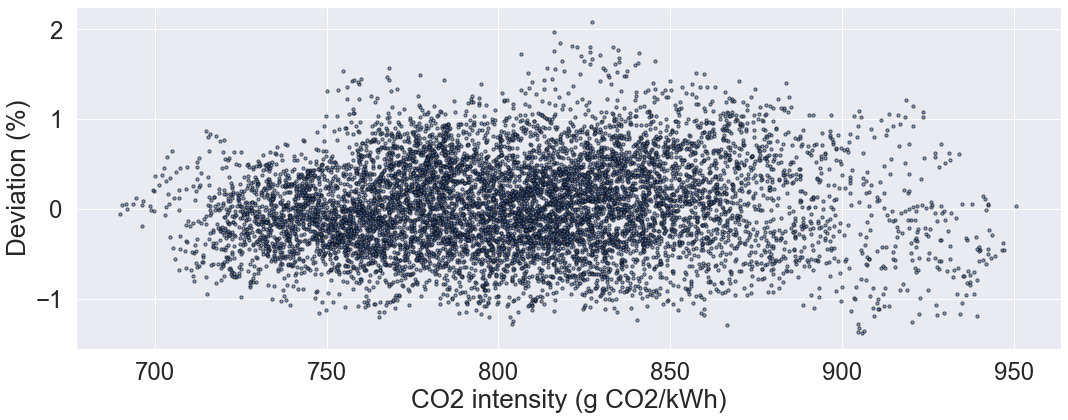

In [26]:
Carbon_intensitiy

fig,ax = plt.subplots(1,1)
    
#fig.set_size_inches(12,6)


Carbon_intensitiy.plot(kind='scatter', x="tech_EF", y="diff_norm_unit_vs_tech", ax=ax, alpha=0.6, s=10, edgecolor='black', color='b')

ax.set_ylabel("Deviation (%)", fontsize=26)
ax.set_xlabel("CO2 intensity (g CO2/kWh)" , fontsize=26)

ax.tick_params(axis='x',labelsize=24)
ax.tick_params(axis='y',labelsize=24)

fig.tight_layout()

pass

In [27]:
fig.savefig(os.path.join(output_directory_path + '/_CO2_intensity_deviation_tech_vs_unit.png'))

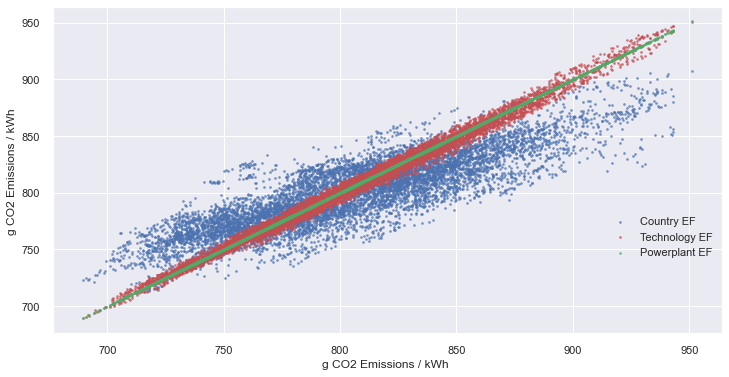

In [28]:
fig,ax = plt.subplots(1,1)
    
fig.set_size_inches(12,6)


Carbon_intensitiy.plot(kind='scatter', x="unit_EF", y="country_EF", ax=ax, alpha=0.6, color='b', s=3)

Carbon_intensitiy.plot(kind='scatter', x="unit_EF", y="tech_EF", ax=ax, alpha=0.6, color='r', s=3)

Carbon_intensitiy.plot(kind='scatter', x="unit_EF", y="unit_EF", ax=ax, alpha=0.6, color='g', s=3)



ax.set_ylabel("g CO2 Emissions / kWh ")
ax.set_xlabel("g CO2 Emissions / kWh ")

ax.legend(['Country EF', 'Technology EF', 'Powerplant EF'] ,loc='lower right', bbox_to_anchor=(1.0, 0.2))

In [29]:
Carbon_intensitiy_per_country_unit_EF = ((CO2_emission_per_unit_EF * 1000000).groupby(generation_unit_info.MapCode, axis=1).sum()) / (generation_per_unit * 1000).groupby(generation_unit_info.MapCode, axis=1).sum()
Carbon_intensitiy_per_country_tech_EF = (CO2_emission_per_tech_EF * 1000000).groupby(generation_unit_info.MapCode, axis=1).sum() / (generation_per_unit * 1000).groupby(generation_unit_info.MapCode, axis=1).sum()
Carbon_intensitiy_per_country_country_EF = (CO2_emission_per_country_EF * 1000000).groupby(generation_unit_info.MapCode, axis=1).sum() / (generation_per_unit * 1000).groupby(generation_unit_info.MapCode, axis=1).sum()

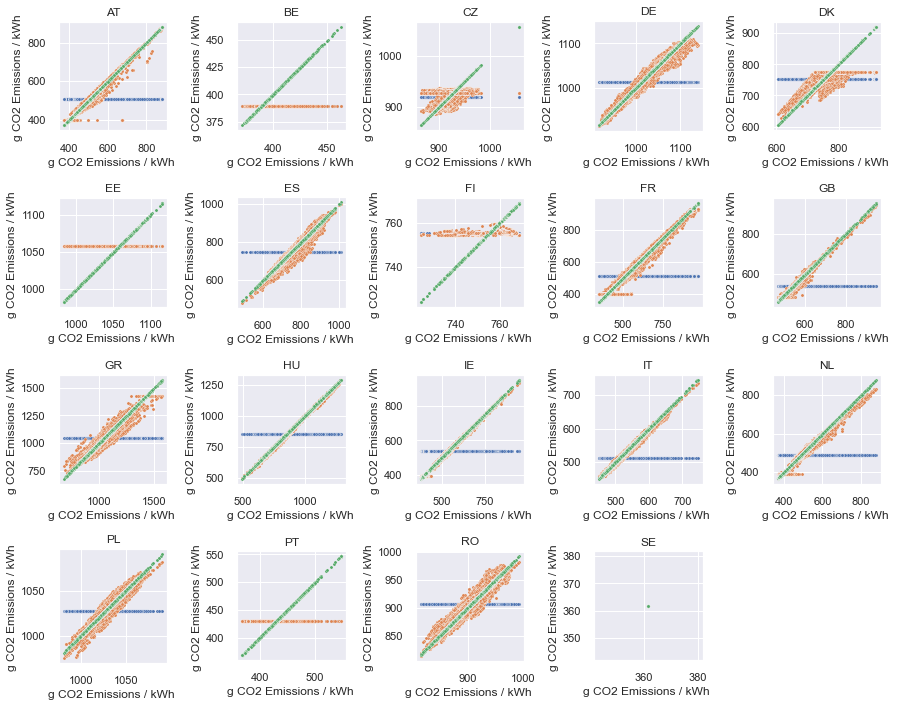

In [30]:
n_graphs = len(Carbon_intensitiy_per_country_unit_EF.columns)
n_cols = 5
    
if n_graphs % n_cols == 0:
    n_rows = n_graphs // n_cols
else:
    n_rows = n_graphs // n_cols + 1
    
    
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)

fig.delaxes(axes[3][4])

size = 2.5

fig.set_size_inches(size*n_cols,size*n_rows)
    
    
for i, country in enumerate(Carbon_intensitiy_per_country_unit_EF.columns):
    i_row = i // n_cols
    i_col = i % n_cols
        
    ax = axes[i_row,i_col]
    
    ax.set(aspect='equal')
    
    sns.scatterplot(x=Carbon_intensitiy_per_country_unit_EF.loc[:,country], y=Carbon_intensitiy_per_country_country_EF.loc[:,country], s=10, ax=ax)
    sns.scatterplot(x=Carbon_intensitiy_per_country_unit_EF.loc[:,country], y=Carbon_intensitiy_per_country_tech_EF.loc[:,country], s=10, ax=ax)
    sns.scatterplot(x=Carbon_intensitiy_per_country_unit_EF.loc[:,country], y=Carbon_intensitiy_per_country_unit_EF.loc[:,country], s=10, ax=ax)
    
        #max_lim = (max(entso_DE.loc[:,tech].max(),generation_DE.loc[:,tech].max())//1000)*1000+1000
        #if max_lim < 0:
        #    max_lim = 0
        
        #min_lim = (min(entso_DE.loc[:,tech].min(),generation_DE.loc[:,tech].min())//1000)*1000-1000
        #if min_lim < 0:
        #    min_lim = 0
    
    ax.set_title(country)
        #ax.set_xlim(min_lim,max_lim)
        #ax.set_ylim(min_lim,max_lim)
        
    ax.set_xlabel("g CO2 Emissions / kWh ")
    ax.set_ylabel("g CO2 Emissions / kWh ")
    
    fig.tight_layout()
    
ax.legend(['Country EF', 'Technology EF', 'Powerplant EF'] ,loc='lower right', bbox_to_anchor=(2.8, 0.5))

#### EF distribution

Text(0.5, 0, 'Country')

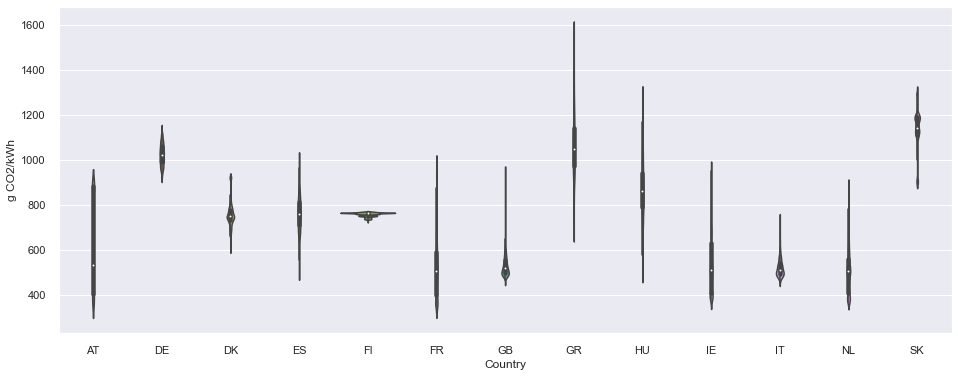

In [31]:
# per unit EF
fig,ax = plt.subplots(1,1)
    
fig.set_size_inches(16,6)
ax = sns.violinplot(data=Carbon_intensitiy_per_country_unit_EF[['AT', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'GR', 'HU', 'IE',
       'IT', 'NL', 'SK']])#,'BE']])

ax.set_ylabel("g CO2/kWh")
ax.set_xlabel("Country")

Text(0.5, 0, 'Country')

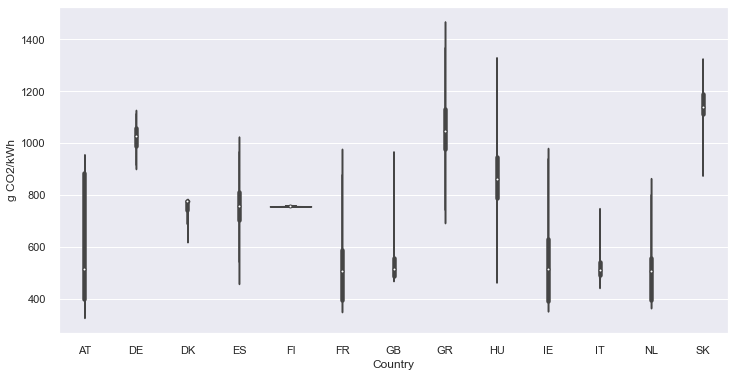

In [32]:
# per tech ef
fig,ax = plt.subplots(1,1)
    
fig.set_size_inches(12,6)

ax = sns.violinplot(data=Carbon_intensitiy_per_country_tech_EF[['AT', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'GR', 'HU', 'IE',
       'IT', 'NL', 'SK']])#,'BE']])

ax.set_ylabel("g CO2/kWh")
ax.set_xlabel("Country")

Text(0.5, 0, 'Country')

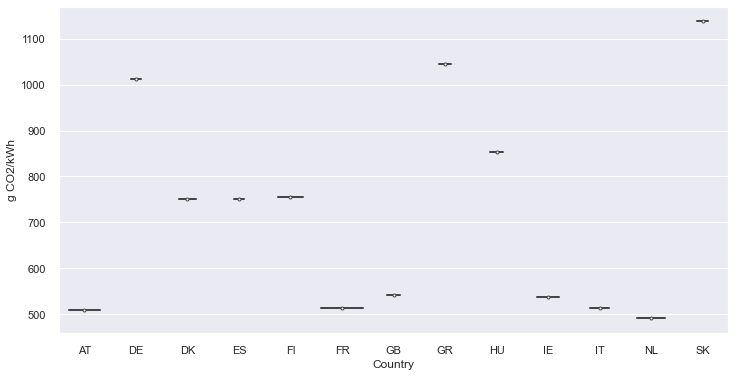

In [33]:
# per country EF
fig,ax = plt.subplots(1,1)
    
fig.set_size_inches(12,6)

ax = sns.violinplot(data=Carbon_intensitiy_per_country_country_EF[['AT', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'GR', 'HU', 'IE',
       'IT', 'NL', 'SK']])#,'BE']])

ax.set_ylabel("g CO2/kWh")
ax.set_xlabel("Country")

## CO2 Signal Example

The following plot shows an example of the three generated CO2 Signals

In [34]:
def plot_production_profile(generation, CO2_emission_per_unit_EF, CO2_emission_per_tech_EF, CO2_emission_per_country_EF, generators, countries, start, end):
    
    # load and filter data
    generators = generators[generators.MapCode == countries]
    generation = generation[generators.index]
    CO2_emission_per_unit_EF = CO2_emission_per_unit_EF[generators.index]
    CO2_emission_per_tech_EF = CO2_emission_per_tech_EF[generators.index]
    CO2_emission_per_country_EF = CO2_emission_per_country_EF[generators.index]
    
    # sum technologies
    generation_car =  generation.groupby(generators.ProductionTypeName, axis=1).sum()
    
    # sum Emissions
    CO2_emission_per_unit_EF = CO2_emission_per_unit_EF.sum(axis=1)
    CO2_emission_per_tech_EF = CO2_emission_per_tech_EF.sum(axis=1)
    CO2_emission_per_country_EF = CO2_emission_per_country_EF.sum(axis=1)
    
    # Carbon intensity
    Carbon_intensitiy_unit_EF = (CO2_emission_per_unit_EF * 1000000) / ((generation_car * 1000).sum(axis=1))
    Carbon_intensitiy_tech_EF = (CO2_emission_per_tech_EF * 1000000) / ((generation_car * 1000).sum(axis=1))
    Carbon_intensitiy_country_EF = (CO2_emission_per_country_EF * 1000000) / ((generation_car * 1000).sum(axis=1))
    
    #plotting
    import seaborn as sns

    sns.set(style="whitegrid")

    colors = {'gas': '#b20101',
              'biomass': '#0c6013',
              'hard_coal': '#707070',
              'geothermal': '#ba91b1',
              'lignite': '#9e5a01',
              'nuclear': '#ff9000',
              'oil': '#262626',
              'other_fossil': '#d35050',
              'waste': '#68896b',
              'onwind': '#235ebc',
              'offwind': '#6895dd',
              'solar': '#f9d002',
              'PHS': '#08ad97',
              'hydro': '#08ad97',
              'ror': '#4adbc8',
              'load': '#ea048a'}

    generation_car = generation_car.loc[start:end]
    Carbon_intensitiy_unit_EF = Carbon_intensitiy_unit_EF.loc[start:end]
    Carbon_intensitiy_tech_EF = Carbon_intensitiy_tech_EF.loc[start:end]
    Carbon_intensitiy_country_EF = Carbon_intensitiy_country_EF.loc[start:end]


    #order of col
    #cols = ['lignite', 'hard_coal',  'gas']#, 'other_fossil']

    #p_by_carrier = p_by_carrier[cols]



    fig,ax = plt.subplots(1,1)

    fig.set_size_inches(12,6)

    generation_car.plot(kind="area",
                        ax=ax,
                        linewidth=0,
                        color=[colors[col] for col in generation_car.columns],
                        alpha=0.7)



    ax.set_ylabel("Production [MW]")
    ax.set_xlabel("Date")
    ax.legend(loc='upper right', bbox_to_anchor=(1.0, 0.5))

    #ax3 = ax.twinx()
    Carbon_intensitiy_unit_EF.plot(ax=ax, secondary_y=True, legend=False)


    Carbon_intensitiy_tech_EF.plot(ax=ax, secondary_y=True, legend=False)

    Carbon_intensitiy_country_EF.plot(ax=ax, secondary_y=True, legend=False)

    ax.right_ax.set_ylabel("Emission intensity [g CO2 / kWh]")

    #ax.set_xlim(0,snapLength-1)
    #ax.set_ylim(0,150000)
    #ax.right_ax.set_ylim(0,0.1)
    plt.tight_layout()
    
    return

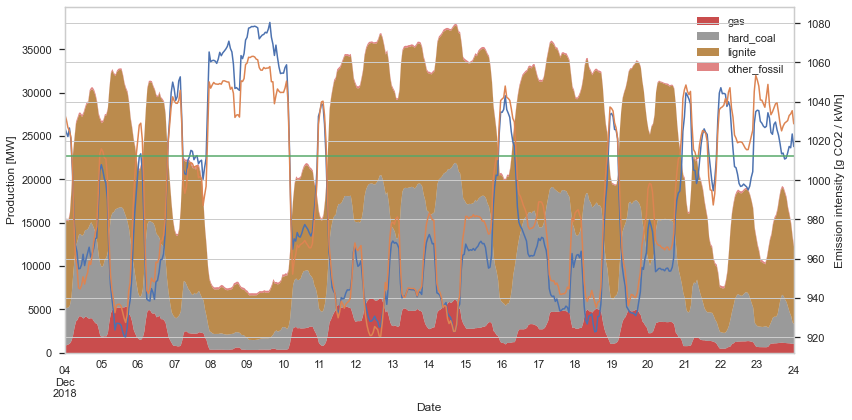

In [35]:
start = datetime.date(2018, 12, 4)
end = datetime.date(2018, 12, 24)

#Carbon_intensitiy_per_country_unit_EF
#Carbon_intensitiy_per_country_tech_EF
#Carbon_intensitiy_per_country_country_EF

plot_production_profile(generation_per_unit, CO2_emission_per_unit_EF, CO2_emission_per_tech_EF, CO2_emission_per_country_EF, generation_unit_info, 'DE', start, end)


# ENTSO-E generation per technology CO2 Signal

In this section we using the country specific EF for generating an CO2 emission signal for all EU countries. The production data are based on the production per type data from ENTSO-E

In [36]:
# take a look at the generation data
entsoe_gen_type.head(5)

region                         AT                                      \
variable                  biomass        gas   hard_coal        hydro   
utc_timestamp                                                           
2018-01-01 00:00:00+00:00   316.0  85.185998  189.813350  3633.105979   
2018-01-01 01:00:00+00:00   316.0  83.986195  188.547928  3557.076855   
2018-01-01 02:00:00+00:00   316.0  82.786393  188.547928  3439.774779   
2018-01-01 03:00:00+00:00   316.0  86.385801  188.547928  3432.171866   
2018-01-01 04:00:00+00:00   316.0  89.985209  188.547928  3616.814024   

region                                                               \
variable                  other_fossil other_renewable solar  waste   
utc_timestamp                                                         
2018-01-01 00:00:00+00:00   376.712329             0.0   0.0  100.0   
2018-01-01 01:00:00+00:00   376.712329             0.0   0.0  100.0   
2018-01-01 02:00:00+00:00   376.712329             0.0   0.0  100.0   
2018-01-01 03:00:00+00:00   376.712329             0.0   0.0  100.0   
2018-01-01 04:00:00+00:00   376.712329             0.0   0.0  100.0   

region                                          BE  ...      SK          \
variable                  wind_onshore     biomass  ... lignite nuclear   
utc_timestamp                                       ...                   
2018-01-01 00:00:00+00:00        832.0  310.564338  ...   179.5  1819.3   
2018-01-01 01:00:00+00:00        926.0  205.181412  ...   177.9  1816.7   
2018-01-01 02:00:00+00:00        692.0  178.621922  ...   174.7  1808.7   
2018-01-01 03:00:00+00:00        453.0  175.522424  ...   168.5  1803.6   
2018-01-01 04:00:00+00:00        321.0  175.362106  ...   170.6  1809.1   

region                                                                 SE  \
variable                  other_fossil other_renewable solar      biomass   
utc_timestamp                                                               
2018-01-01 00:00:00+00:00        478.8            41.4   0.0  1359.856555   
2018-01-01 01:00:00+00:00        475.8            41.0   0.0  1368.550363   
2018-01-01 02:00:00+00:00        469.5            40.8   0.0  1276.057900   
2018-01-01 03:00:00+00:00        455.6            39.4   0.0  1272.797722   
2018-01-01 04:00:00+00:00        461.5            40.4   0.0  1272.918469   

region                                                                      
variable                        gas  hard_coal other_renewable       waste  
utc_timestamp                                                               
2018-01-01 00:00:00+00:00  0.000000  78.739970      177.034950  101.343265  
2018-01-01 01:00:00+00:00  0.000000  56.544811      178.126795  101.959602  
2018-01-01 02:00:00+00:00  0.000000   0.000000      164.712693   94.387472  
2018-01-01 03:00:00+00:00  0.000000   0.000000      164.244759   94.123328  
2018-01-01 04:00:00+00:00  0.146956   0.000000      164.244759   94.123328  

[5 rows x 219 columns]

## EF preparation 

In [37]:
EF

EF  Verified_EF  Coverage  \
MapCode ProductionTypeName                                    
AT      gas                 0.398292        False      24.0   
        hard_coal           0.884070         True      39.0   
BE      gas                 0.389641         True      64.0   
CZ      gas                 0.780843         True      39.0   
        hard_coal           0.985546         True      36.0   
        lignite             0.928296         True      58.0   
DE      gas                 0.354596        False      17.0   
        hard_coal           0.934135         True      94.0   
        lignite             1.125560         True      96.0   
        other_fossil        1.401101         True      30.0   
DK      gas                 0.329783        False      10.0   
        hard_coal           0.775840         True      69.0   
EE      other_fossil        1.057973         True     109.0   
ES      gas                 0.390428         True      49.0   
        hard_coal           1.044871         True      99.0   
FI      hard_coal           0.754586         True      47.0   
        other_fossil        0.759814        False      13.0   
FR      gas                 0.396985         True      49.0   
        hard_coal           0.928832         True      73.0   
GB      gas                 0.488643         True      64.0   
        hard_coal           1.124997         True      46.0   
GR      gas                 0.457378         True      65.0   
        lignite             1.429216         True     100.0   
HU      gas                 0.379650         True      65.0   
        lignite             1.355619         True      81.0   
IE      gas                 0.392880         True      44.0   
        hard_coal           1.032204         True      89.0   
IT      gas                 0.395166         True      52.0   
        hard_coal           0.997673         True      59.0   
        other_fossil        0.458371        False      22.0   
NL      gas                 0.393243         True      40.0   
        hard_coal           1.183066        False      24.0   
PL      gas                 0.370311        False      10.0   
        hard_coal           0.942409         True      56.0   
        lignite             1.158647         True      78.0   
PT      gas                 0.430328         True      42.0   
RO      gas                 0.426421         True      28.0   
        hard_coal           1.157439         True      72.0   
        lignite             1.000763         True      88.0   
SE      gas                 0.361805         True      68.0   
SK      hard_coal           0.903090         True      65.0   
        lignite             1.295547         True      87.0   

                            EF_round_in_gCO2_kwh  
MapCode ProductionTypeName                        
AT      gas                               398.29  
        hard_coal                         884.07  
BE      gas                               389.64  
CZ      gas                               780.84  
        hard_coal                         985.55  
        lignite                           928.30  
DE      gas                               354.60  
        hard_coal                         934.14  
        lignite                          1125.56  
        other_fossil                     1401.10  
DK      gas                               329.78  
        hard_coal                         775.84  
EE      other_fossil                     1057.97  
ES      gas                               390.43  
        hard_coal                        1044.87  
FI      hard_coal                         754.59  
        other_fossil                      759.81  
FR      gas                               396.98  
        hard_coal                         928.83  
GB      gas                               488.64  
        hard_coal                        1125.00  
GR      gas                               457.38  
        lignite                      

In [38]:
EF_mean = EF.groupby('ProductionTypeName').mean()

#### old ####
# Using a mean EF for other fossils of 0.75 because we only cover some countries with other fossils
# and the resulting mean EF would be above 1.0, which seems too high.
# EF_mean.loc['other_fossil'] = 0.75
# converting EF_mean to a diconary
#### old ####

EF_mean = EF_mean.EF.to_dict()

#show resulting EF
print(EF_mean)

{'gas': 0.41978787102138526, 'hard_coal': 0.9749115732664191, 'lignite': 1.1848068573544648, 'other_fossil': 0.9193148563890987}


In [39]:
# If no country-specific EFs are available and also no mean EF is available for a country and technology,
# we use the following standard EFs. In addition, we define for the renewable generation types a EF with
# an emission value of 0.

EF_default = {'biomass':0,
              'geothermal':0,
              'hydro':0,
              'nuclear':0,
              'oil':0.8,
              'other_renewable':0,
              'solar':0,
              'waste':0.2,
              'wind_offshore':0,
              'wind_onshore':0,
              'marine':0,
              'oil shale':0.51}

In [40]:
# Create a dataframe with the EF for each country and technology. If no specific EF is available, we use the default EF.
EF_multi = {}

for i in entsoe_gen_type.columns:
    if i in EF.index:
        print(str(i)+' EF')
        EF_multi[i] = EF.loc[i[0],i[1]].loc['EF']
    elif i[1] in EF_mean:
        print(str(i) +' EF_mean')
        EF_multi[i] = EF_mean[i[1]]
    else:
        print(str(i) + ' EF_default')
        EF_multi[i] = EF_default[i[1]]

('AT', 'biomass') EF_default
('AT', 'gas') EF
('AT', 'hard_coal') EF
('AT', 'hydro') EF_default
('AT', 'other_fossil') EF_mean
('AT', 'other_renewable') EF_default
('AT', 'solar') EF_default
('AT', 'waste') EF_default
('AT', 'wind_onshore') EF_default
('BE', 'biomass') EF_default
('BE', 'gas') EF
('BE', 'hydro') EF_default
('BE', 'nuclear') EF_default
('BE', 'other_fossil') EF_mean
('BE', 'solar') EF_default
('BE', 'waste') EF_default
('BE', 'wind_offshore') EF_default
('BE', 'wind_onshore') EF_default
('BG', 'biomass') EF_default
('BG', 'gas') EF_mean
('BG', 'hard_coal') EF_mean
('BG', 'hydro') EF_default
('BG', 'lignite') EF_mean
('BG', 'nuclear') EF_default
('BG', 'solar') EF_default
('BG', 'waste') EF_default
('BG', 'wind_onshore') EF_default
('CH', 'hydro') EF_default
('CH', 'nuclear') EF_default
('CH', 'solar') EF_default
('CH', 'wind_onshore') EF_default
('CY', 'other_fossil') EF_mean
('CY', 'wind_onshore') EF_default
('CZ', 'biomass') EF_default
('CZ', 'gas') EF
('CZ', 'hard_co

In [41]:
# calculate emissions based on EF and generation per type
CO2_emission_entsoe_gen_type = entsoe_gen_type * EF_multi

In [42]:
# From the previously calculated emissions, an emission signal (g CO2 / kWh) can now be calculated for each country.
# Since emissions and generation are available per technology, they must first be grouped and summed. 

# Emission in g CO2
CO2_emission = (CO2_emission_entsoe_gen_type * 1000000).groupby(level=0, axis=1).sum()
# generation in kWh
Generation = (entsoe_gen_type * 1000).groupby(level=0, axis=1).sum()

# CI in g CO2/kWh
Carbon_intensitiy_entsoe_gen_type = CO2_emission.div(Generation)

In [43]:
Carbon_intensitiy_entsoe_gen_type.head(5)

region,AT,BE,BG,CH,CY,CZ,DE,DK,EE,ES,...,ME,NL,NO,PL,PT,RO,RS,SE,SI,SK
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,102.669997,113.619524,482.968567,0.0,872.453277,425.245833,201.027162,92.464546,850.334892,125.716484,...,1184.806857,353.518587,13.870972,669.768814,167.342336,360.100410,881.967689,15.967807,270.832349,245.841351
2018-01-01 01:00:00+00:00,102.095308,118.388261,483.101690,0.0,862.449995,422.597980,200.143765,108.328618,856.828593,139.004778,...,1184.806857,354.440314,14.802332,653.910169,172.773764,354.527158,905.330212,14.835960,265.286450,244.305284
2018-01-01 02:00:00+00:00,108.929822,124.864850,483.968791,0.0,813.758407,419.705287,197.012685,101.635235,875.845631,159.835270,...,1184.806857,344.535640,16.350643,644.172587,162.399007,369.630370,911.737976,10.893186,247.188427,237.587952
2018-01-01 03:00:00+00:00,114.563775,123.832771,483.433811,0.0,812.670227,422.350579,197.431298,103.075209,877.583346,160.378908,...,1184.806857,337.560484,16.339003,647.175696,168.837800,377.289097,892.702717,10.922429,254.977985,225.622090
2018-01-01 04:00:00+00:00,113.563662,122.689624,484.757409,0.0,856.003348,427.255629,195.357510,100.778299,875.965159,161.915074,...,1184.806857,336.258948,16.248559,638.422549,169.366289,380.632074,909.142827,10.820705,256.331896,229.409484


In [44]:
mean_Carbon_intensitiy_entsoe_gen_type = CO2_emission.sum() / Generation.sum()

In [45]:
Carbon_intensitiy_entsoe_gen_type_mean = Carbon_intensitiy_entsoe_gen_type.copy()


In [46]:
for i in Carbon_intensitiy_entsoe_gen_type_mean.columns:
    Carbon_intensitiy_entsoe_gen_type_mean[i] = mean_Carbon_intensitiy_entsoe_gen_type[i]

In [47]:
Carbon_intensitiy_entsoe_gen_type_mean.head()

region,AT,BE,BG,CH,CY,CZ,DE,DK,EE,ES,...,ME,NL,NO,PL,PT,RO,RS,SE,SI,SK
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,136.269194,194.792482,527.359493,0.0,879.693287,479.776097,435.147343,223.166315,906.62507,342.768488,...,469.46804,527.357855,16.320712,837.941046,317.054828,321.028807,843.90416,15.362328,342.203141,231.71073
2018-01-01 01:00:00+00:00,136.269194,194.792482,527.359493,0.0,879.693287,479.776097,435.147343,223.166315,906.62507,342.768488,...,469.46804,527.357855,16.320712,837.941046,317.054828,321.028807,843.90416,15.362328,342.203141,231.71073
2018-01-01 02:00:00+00:00,136.269194,194.792482,527.359493,0.0,879.693287,479.776097,435.147343,223.166315,906.62507,342.768488,...,469.46804,527.357855,16.320712,837.941046,317.054828,321.028807,843.90416,15.362328,342.203141,231.71073
2018-01-01 03:00:00+00:00,136.269194,194.792482,527.359493,0.0,879.693287,479.776097,435.147343,223.166315,906.62507,342.768488,...,469.46804,527.357855,16.320712,837.941046,317.054828,321.028807,843.90416,15.362328,342.203141,231.71073
2018-01-01 04:00:00+00:00,136.269194,194.792482,527.359493,0.0,879.693287,479.776097,435.147343,223.166315,906.62507,342.768488,...,469.46804,527.357855,16.320712,837.941046,317.054828,321.028807,843.90416,15.362328,342.203141,231.71073


## Plots

This section is to see some plots for the generated and emission data

### CO2 Signal Example

In [48]:
entsoe_gen_type.columns.levels[1]

Index(['biomass', 'gas', 'hard_coal', 'hydro', 'lignite', 'nuclear',
       'other_fossil', 'other_renewable', 'solar', 'waste', 'wind_offshore',
       'wind_onshore'],
      dtype='object', name='variable')

In [49]:
def plot_production_profile_2(generation, Carbon_intensitiy, mean_Carbon_intensitiy, countries, start, end):
    
    # load and filter data
    generation = generation[countries]
    Carbon_intensitiy = Carbon_intensitiy[countries]
    Carbon_intensitiy_mean = mean_Carbon_intensitiy[countries]
    
    
    #plotting
    import seaborn as sns

    sns.set(style="whitegrid")

    colors = {'gas': '#b20101',
              'biomass': '#0c6013',
              'hard_coal': '#707070',
              'geothermal': '#ba91b1',
              'lignite': '#9e5a01',
              'nuclear': '#ff9000',
              'oil': '#262626',
              'other_fossil': '#d35050',
              'waste': '#68896b',
              'wind_onshore': '#235ebc',
              'wind_offshore': '#6895dd',
              'solar': '#f9d002',
              'PHS': '#08ad97',
              'hydro': '#08ad97',
              'ror': '#4adbc8',
              'load': '#ea048a',
              'other_renewable':'#08ad97'}

    generation = generation.loc[start:end]
    Carbon_intensitiy = Carbon_intensitiy.loc[start:end]
    Carbon_intensitiy_mean = Carbon_intensitiy_mean.loc[start:end]



    #order of col
    tech = ['biomass', 'nuclear','lignite', 'hard_coal','geothermal', 'hydro', 'gas','waste', 'oil', 'other_fossil', 'other_renewable', 'solar',  'wind_offshore', 'wind_onshore']
    
    filter = generation.columns
    
    cols = [k for k in tech if k in filter]

    generation = generation[cols]



    fig,ax = plt.subplots(1,1)

    fig.set_size_inches(16,6)

    generation.plot(kind="area",
                        ax=ax,
                        linewidth=0,
                        color=[colors[col] for col in generation.columns],
                        alpha=0.7)



    ax.set_ylabel("Production (MW)", fontsize=14)
    ax.set_xlabel("Date", fontsize=14)
    #ax.legend(loc='center left', bbox_to_anchor=(1.08, 0.5))
    ax.grid(False)
    
    ax2 = fig.add_axes() # This is the magic that joins the x-axis
    ax2 = ax.twinx()

    #ax3 = ax.twinx()
    
    Carbon_intensitiy.plot(ax=ax2, secondary_y=True, legend=False, color="k")
    Carbon_intensitiy_mean.plot(ax=ax2, secondary_y=True, legend=False, color="k", linestyle='--')    
    
        
    handles = [Line2D([0], [0], color='k', lw=2),
               Line2D([0], [0], color='k', linestyle='--', lw=2)
               ]
    
    labels = [str(countries)+ ', using technology-specific EF',str(countries) + ', using country-specific EF']
    
    l2 = ax2.legend(handles, labels,  loc='upper left', bbox_to_anchor=(1.10, 0.90),
                   handletextpad=0., columnspacing=0.5, ncol=1,
                   title='Carbon intensity', fontsize=14, frameon=True)
    
    handles = []
    labels = []
    
    for t in generation.columns:
        handles.append(plt.Line2D([0], [0], color=colors[t], marker='o', markersize=8, linewidth=0, alpha=0.7))
        labels.append(t)
        
    l3 = ax.legend(handles, labels,  bbox_to_anchor=(1.10, 0.7),
                   handletextpad=0., columnspacing=0.5, ncol=2,
                   title='Technology Types', fontsize=14, frameon=True, framealpha=0.6) #loc="upper right", 
    
    


    ax2.right_ax.set_ylabel("Carbon intensity (g CO2 / kWh)", fontsize=14)

    plt.tight_layout()
    plt.show()
    
    return fig

C:\Users\Freddy\.conda\envs\Lecture\lib\site-packages\ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.


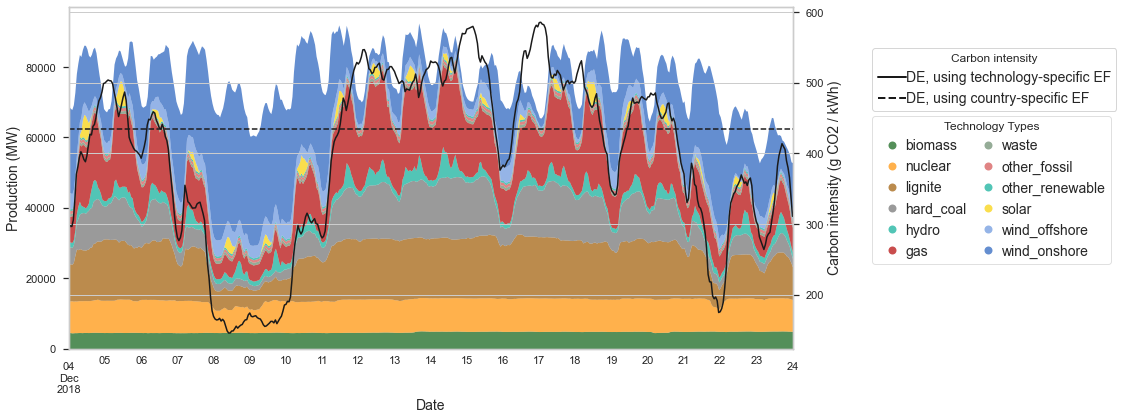

In [50]:
start = datetime.date(2018, 12, 4)
end = datetime.date(2018, 12, 24)

fig = plot_production_profile_2(entsoe_gen_type, Carbon_intensitiy_entsoe_gen_type, Carbon_intensitiy_entsoe_gen_type_mean, 'DE', start, end)

In [51]:
fig.savefig(os.path.join(output_directory_path + '/CO2_signal_example_DE.png'))

C:\Users\Freddy\.conda\envs\Lecture\lib\site-packages\ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.


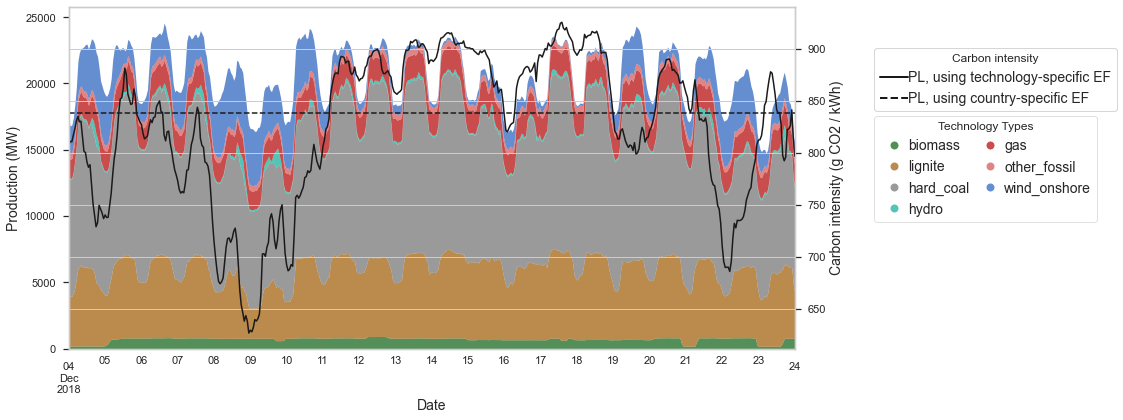

In [52]:
start = datetime.date(2018, 12, 4)
end = datetime.date(2018, 12, 24)

fig = plot_production_profile_2(entsoe_gen_type, Carbon_intensitiy_entsoe_gen_type, Carbon_intensitiy_entsoe_gen_type_mean, 'PL', start, end)

In [53]:
fig.savefig(os.path.join(output_directory_path + '/CO2_signal_example_PL.png'))

C:\Users\Freddy\.conda\envs\Lecture\lib\site-packages\ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.


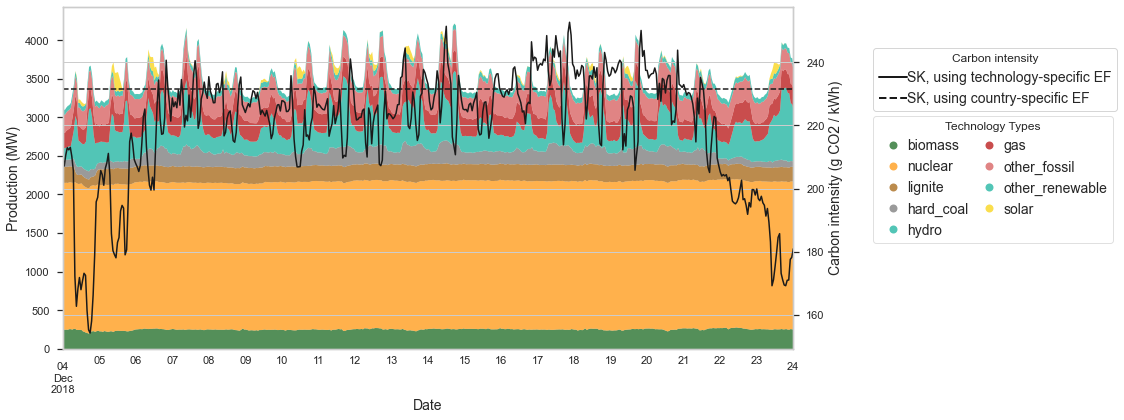

In [54]:
start = datetime.date(2018, 12, 4)
end = datetime.date(2018, 12, 24)

fig = plot_production_profile_2(entsoe_gen_type, Carbon_intensitiy_entsoe_gen_type, Carbon_intensitiy_entsoe_gen_type_mean, 'SK', start, end)

C:\Users\Freddy\.conda\envs\Lecture\lib\site-packages\ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.


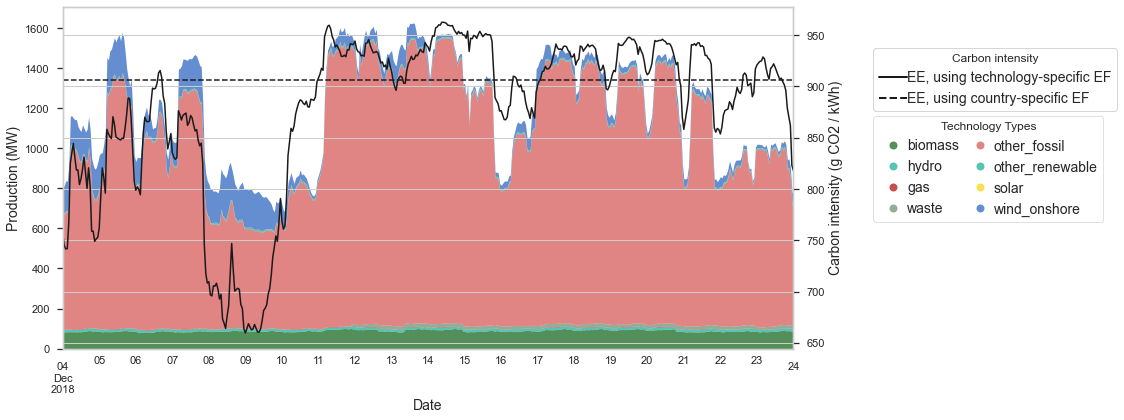

In [55]:
start = datetime.date(2018, 12, 4)
end = datetime.date(2018, 12, 24)

fig = plot_production_profile_2(entsoe_gen_type, Carbon_intensitiy_entsoe_gen_type, Carbon_intensitiy_entsoe_gen_type_mean, 'EE', start, end)

### CO2 Duration Curves

In [56]:
countries = Carbon_intensitiy_entsoe_gen_type[EF.index.levels[0]].columns

In [57]:
countries

Index(['AT', 'BE', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR', 'HU',
       'IE', 'IT', 'NL', 'PL', 'PT', 'RO', 'SE', 'SK'],
      dtype='object', name='region')

In [58]:
Carbon_intensitiy_entsoe_gen_type

region,AT,BE,BG,CH,CY,CZ,DE,DK,EE,ES,...,ME,NL,NO,PL,PT,RO,RS,SE,SI,SK
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,102.669997,113.619524,482.968567,0.0,872.453277,425.245833,201.027162,92.464546,850.334892,125.716484,...,1184.806857,353.518587,13.870972,669.768814,167.342336,360.100410,881.967689,15.967807,270.832349,245.841351
2018-01-01 01:00:00+00:00,102.095308,118.388261,483.101690,0.0,862.449995,422.597980,200.143765,108.328618,856.828593,139.004778,...,1184.806857,354.440314,14.802332,653.910169,172.773764,354.527158,905.330212,14.835960,265.286450,244.305284
2018-01-01 02:00:00+00:00,108.929822,124.864850,483.968791,0.0,813.758407,419.705287,197.012685,101.635235,875.845631,159.835270,...,1184.806857,344.535640,16.350643,644.172587,162.399007,369.630370,911.737976,10.893186,247.188427,237.587952
2018-01-01 03:00:00+00:00,114.563775,123.832771,483.433811,0.0,812.670227,422.350579,197.431298,103.075209,877.583346,160.378908,...,1184.806857,337.560484,16.339003,647.175696,168.837800,377.289097,892.702717,10.922429,254.977985,225.622090
2018-01-01 04:00:00+00:00,113.563662,122.689624,484.757409,0.0,856.003348,427.255629,195.357510,100.778299,875.965159,161.915074,...,1184.806857,336.258948,16.248559,638.422549,169.366289,380.632074,909.142827,10.820705,256.331896,229.409484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+00:00,198.522207,241.459810,630.077375,0.0,872.843743,515.792660,341.976521,118.127572,663.360908,249.634886,...,555.287759,529.211270,37.259118,753.014420,296.257113,355.636688,923.053323,27.013335,211.878053,186.235072
2018-12-31 20:00:00+00:00,199.778841,236.283305,645.552691,0.0,826.788843,516.558664,328.507386,117.490553,644.086418,252.088343,...,619.084098,524.622293,38.699092,750.050581,332.813043,352.576059,936.024129,27.937738,248.095874,189.034943
2018-12-31 21:00:00+00:00,200.760662,222.697236,645.389573,0.0,804.604773,486.516899,316.533857,110.330230,640.002975,251.792575,...,625.540022,524.063030,36.952628,736.830785,416.631351,384.856884,916.950344,28.785161,274.079021,196.155534


#### One Figure

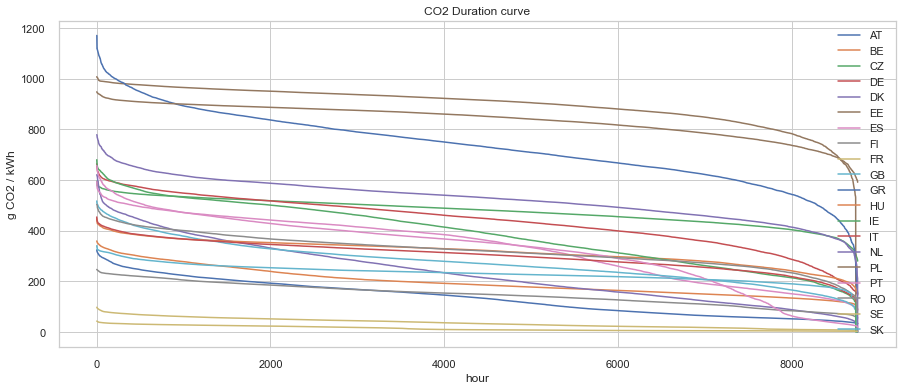

In [59]:
fig, ax = plt.subplots()

for i in countries:    
    ax.plot(range(0,8760), Carbon_intensitiy_entsoe_gen_type[i].sort_values(ascending=False), label = 'CO2 Duration curve')


    
ax.legend(countries ,loc='upper right')
ax.set_xlabel('hour')
ax.set_ylabel('g CO2 / kWh')
plt.title('CO2 Duration curve')
plt.show()

#### Multi sub Figures

In [60]:
c = ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB',
       'GR', 'HU', 'IE', 'IT', 'LT', 'LV', 'NL', 'NO', 'PL', 'PT', 'RO', 'SE',
       'SI', 'SK']

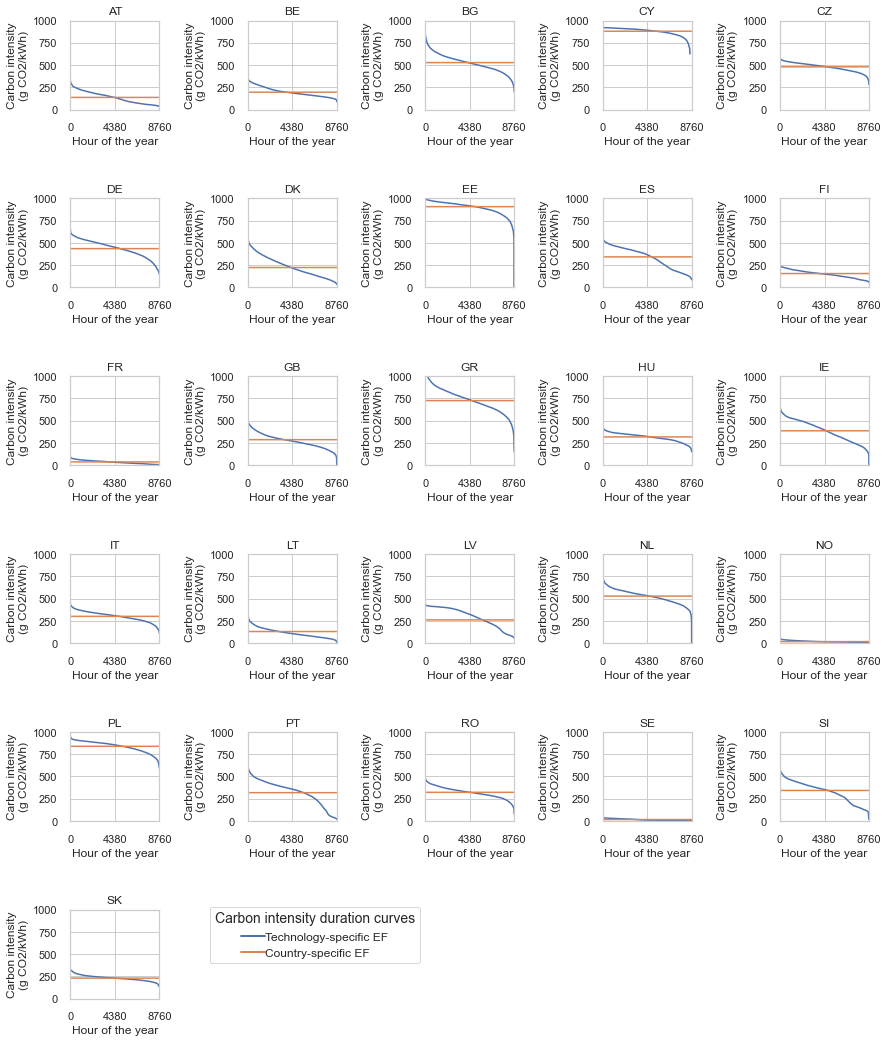

In [61]:
countries = c # Carbon_intensitiy_entsoe_gen_type.columns
n_graphs = len(c) #Carbon_intensitiy_entsoe_gen_type.columns)
#n_graphs = len(Carbon_intensitiy_entsoe_gen_type[EF.index.levels[0]].columns)

n_cols = 5
    
if n_graphs % n_cols == 0:
    n_rows = n_graphs // n_cols
else:
    n_rows = n_graphs // n_cols + 1
    
    
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)

fig.delaxes(axes[5][1])
fig.delaxes(axes[5][2])
fig.delaxes(axes[5][3])
fig.delaxes(axes[5][4])


size = 2.5

fig.set_size_inches(size*n_cols,size*n_rows)
    
    
for i, country in enumerate(c):
    i_row = i // n_cols
    i_col = i % n_cols
        
    ax = axes[i_row,i_col]
        
    ax.plot(range(0,8760), Carbon_intensitiy_entsoe_gen_type[country].sort_values(ascending=False))
    ax.plot(range(0,8760), ([mean_Carbon_intensitiy_entsoe_gen_type[country]]*8760))
    
    ax.set_title(country, fontsize=12)
    ax.set_xlim(0,8760)
    ax.set_ylim(0,1000)
    
    ax.set_xticks([0,4380,8760])
        
    ax.set_xlabel("Hour of the year", fontsize=12)
    ax.set_ylabel("Carbon intensity\n(g CO2/kWh)", fontsize=12)
    ax.set_aspect(8.760)
    fig.tight_layout()

handles = [Line2D([0], [0], color='C0', lw=2),
           Line2D([0], [0], color='C1', lw=2)
           ]
    
labels = ['Technology-specific EF','Country-specific EF']
    
l2 = ax.legend(handles, labels,  loc='upper left', bbox_to_anchor=(1.50, 1.10),
                   handletextpad=0., columnspacing=0.5, ncol=1,
                   title='Carbon intensity duration curves', fontsize=12, title_fontsize= 14, frameon=True)



In [62]:
Carbon_intensitiy_entsoe_gen_type.isnull().sum()

region
AT      0
BE      0
BG      0
CH      0
CY    162
CZ      0
DE      0
DK      0
EE     21
ES      0
FI      0
FR      0
GB      0
GR      0
HU      0
IE      0
IT      9
LT     22
LV      3
ME    420
NL      0
NO      0
PL      0
PT      0
RO      5
RS      0
SE      0
SI      0
SK     69
dtype: int64

In [63]:
fig.savefig(os.path.join(output_directory_path + '/CO2_duration_curve.png'),bbox_extra_artists=(l2,), bbox_inches='tight')

### Carbon Intensity Heat Map 

<AxesSubplot:xlabel='utc_timestamp', ylabel='region'>

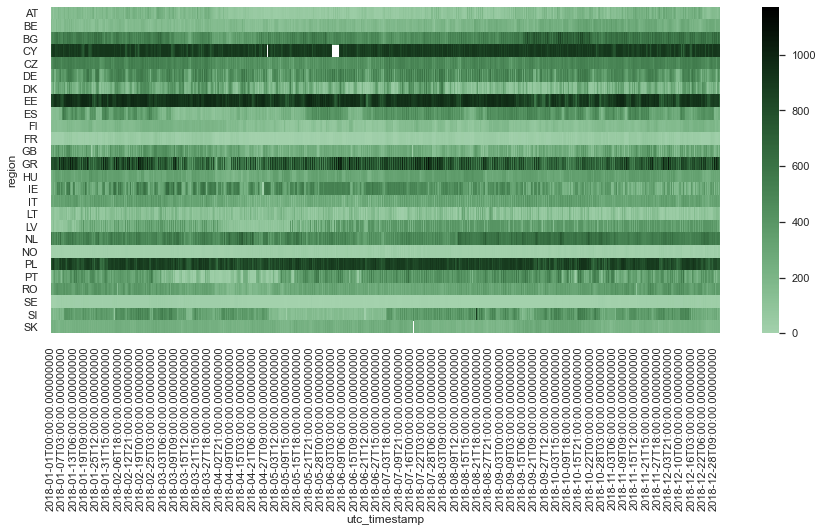

In [64]:
# all countries
sns.heatmap(Carbon_intensitiy_entsoe_gen_type[countries].transpose(), cmap=sns.cubehelix_palette(start=2, rot=0, dark=0, light=.75, reverse=False, as_cmap=True))

In [65]:
# use Germany as an single country example
df = Carbon_intensitiy_entsoe_gen_type['DE'].to_frame().copy()

In [66]:
df.head()

,DE
utc_timestamp,
2018-01-01 00:00:00+00:00,201.027162
2018-01-01 01:00:00+00:00,200.143765
2018-01-01 02:00:00+00:00,197.012685
2018-01-01 03:00:00+00:00,197.431298
2018-01-01 04:00:00+00:00,195.357510


In [67]:
# def names for the heat map
df['month'] = df.index.month_name()
df['day'] = df.index.day_name()
df['hour']=df.index.hour
df['date']=df.index.date
df.head()

,DE,month,day,hour,date
utc_timestamp,,,,,
2018-01-01 00:00:00+00:00,201.027162,January,Monday,0,2018-01-01
2018-01-01 01:00:00+00:00,200.143765,January,Monday,1,2018-01-01
2018-01-01 02:00:00+00:00,197.012685,January,Monday,2,2018-01-01
2018-01-01 03:00:00+00:00,197.431298,January,Monday,3,2018-01-01
2018-01-01 04:00:00+00:00,195.357510,January,Monday,4,2018-01-01


In [68]:
# group the values
df1 = df.groupby(['month', 'hour'],sort=False).agg(['mean'])
df1.columns=df1.columns.droplevel(0)
df1.reset_index(inplace=True)
df1.head()

,month,hour,mean
0,January,0,378.157046
1,January,1,375.276795
2,January,2,373.570026
3,January,3,376.381363
4,January,4,387.117251


In [69]:
# pandas pivot with multiple variables
heatmap_data = pd.pivot_table(df1, values='mean', index=['month'], columns='hour')
# print to see few rows and columns
print(heatmap_data.iloc[0:3, 0:3])

hour               0           1           2
month                                       
April     437.659599  434.142856  436.585863
August    501.374209  501.744677  505.628680
December  359.759737  358.441115  358.587862


In [70]:
months=df1.month.unique().tolist()
print(months)

['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


In [71]:
heatmap_data=heatmap_data.loc[months]

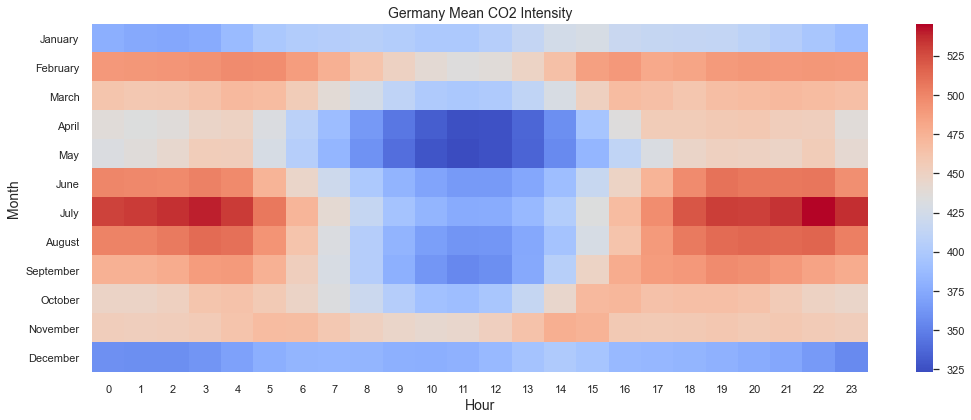

In [72]:
sns.heatmap(heatmap_data,cmap="coolwarm")
plt.xlabel("Hour", size=14)
plt.ylabel("Month", size=14)
plt.title("Germany Mean CO2 Intensity", size=14)
plt.tight_layout()

### Carbon Intensity mean per week

This code was developed by Ramiz Qussous and kindly provided for this project. 

In [73]:
import numpy as np

In [74]:
data = Carbon_intensitiy_entsoe_gen_type.copy()

In [75]:
data['weekOfYear'] = data.index.isocalendar().week
data['weekday'] = data.index.dayofweek
data['hour'] = data.index.hour

dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
data['weekday'] = data.index.dayofweek#.map(dayOfWeek)

weeklyData = data.groupby(['weekday',data['hour']]).mean()[['DE']]
weeklyData_1 = data.groupby(['weekOfYear','weekday',data['hour']]).mean()[['DE']]

weeklyData.columns = ['mean']

for i in range(1,53):
    weeklyData['week {}'.format(i)] = weeklyData_1.loc[i,:,:].droplevel(0)

In [76]:
def plot_multiIndex(weeklyData,name):
    for i in range(6):
        weeklyData.loc[(i,24),:]=weeklyData.loc[(i+1,0)]
    
    weeklyData = weeklyData.sort_values('hour', ascending=False).sort_index(level=0)
    def plot_function(x, ax):
        ax = graph[x]
        ax.set_xlabel(xlabel='Test', weight='bold')
        ax.set_xlim(0,24)
        #ax.set_ylim(0,100)
        ax.set_xticks([0,6,12,18])
        rgba_colors = np.zeros((len(weeklyData.xs(x).columns),4))
        rgba_colors[:,2] = 1.0
        rgba_colors[:, 3] = 0.1
        rgba_colors[0, 3] = 1
        return weeklyData.xs(x).plot(ax=ax, legend=False, xlabel=dayOfWeek[x], color=rgba_colors)
    
    n_subplots = len(weeklyData.index.levels[0])
    fig, axes = plt.subplots(nrows=1, ncols=n_subplots, sharey=True, figsize=(14, 8))  # width, height
    
    graph = dict(zip(weeklyData.index.levels[0], axes))
    plots = list(map(lambda x: plot_function(x, graph[x]), graph))
    #ax.tick_params(axis='both', which='both', length=0)
    fig.subplots_adjust(wspace=0)

    #plt.legend()
    plt.show()
    
    return fig

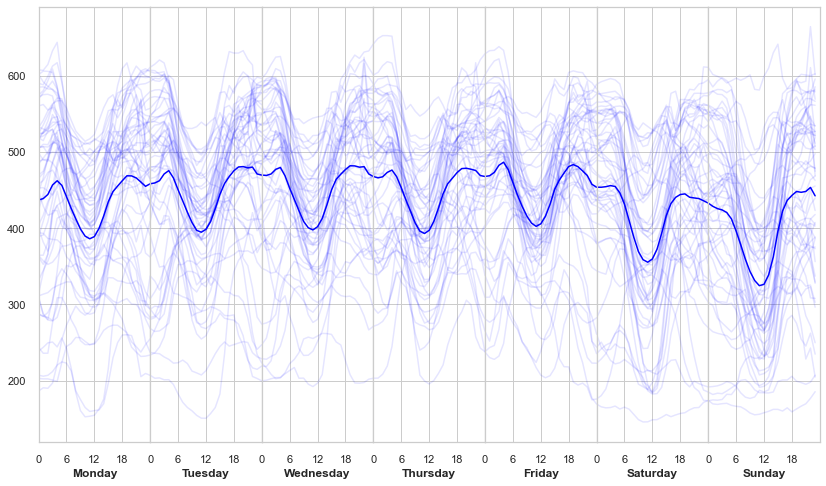

In [77]:
fig = plot_multiIndex(weeklyData,'Total')

In [78]:
fig.savefig(os.path.join(output_directory_path + '/CO2_daily_mean_DE.png'),bbox_extra_artists=(l2,), bbox_inches='tight')

# Export final CO2 signals

In [79]:
Carbon_intensitiy_entsoe_gen_type.to_csv(processed_directory_path + '/CI_bottom_up_method.csv')
Carbon_intensitiy_entsoe_gen_type.to_csv(output_directory_path + '/CI_bottom_up_method.csv')